Make pcm datasets for subsequent analyses

In [1]:
import os
import pickle
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')


import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# Unimanual 12by12 Extrinsic

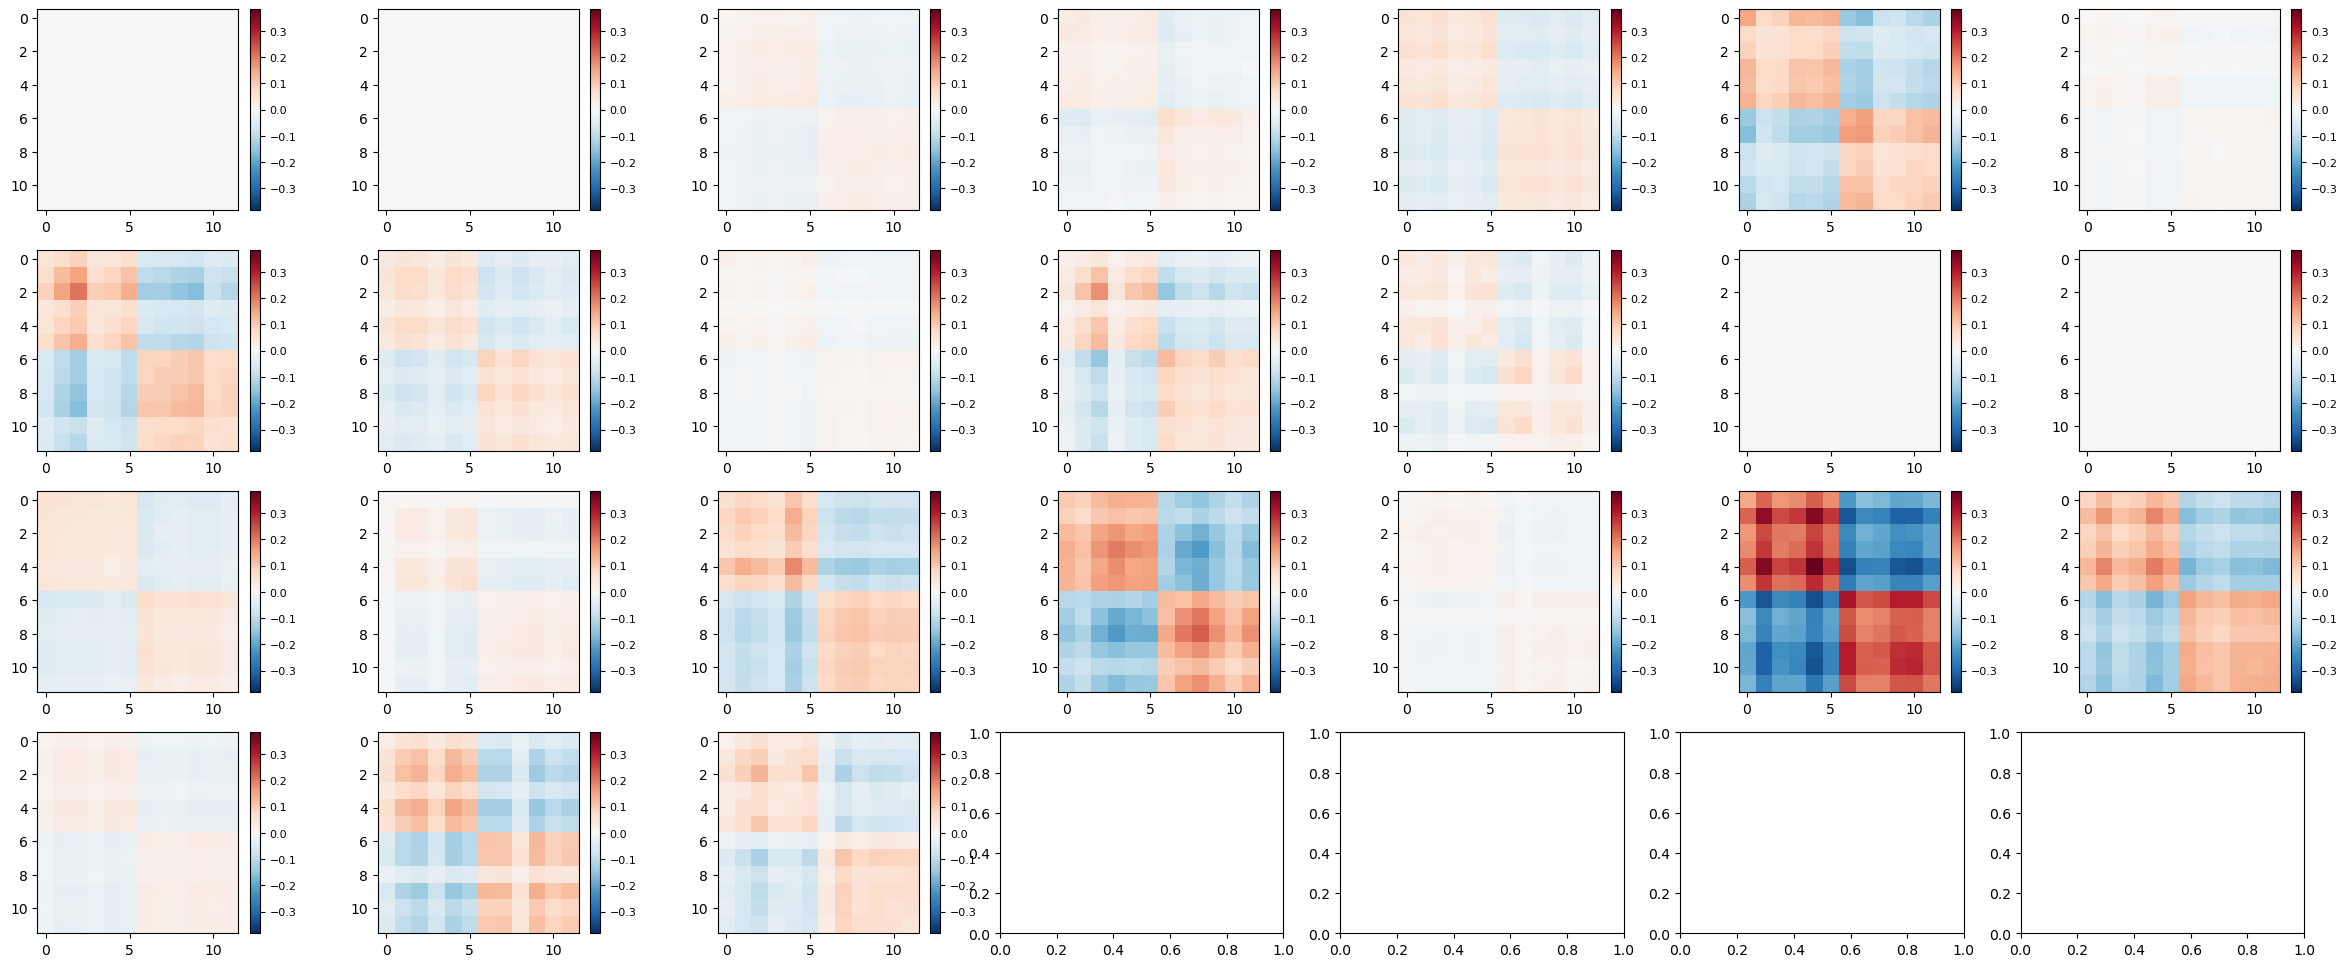

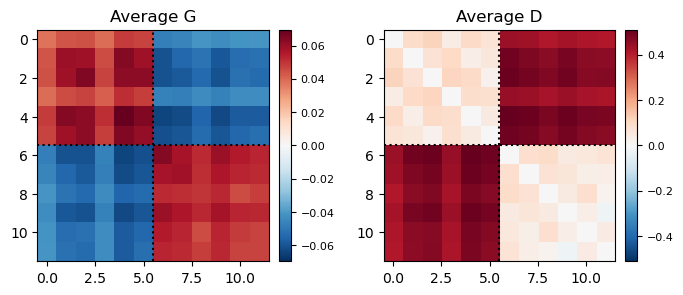

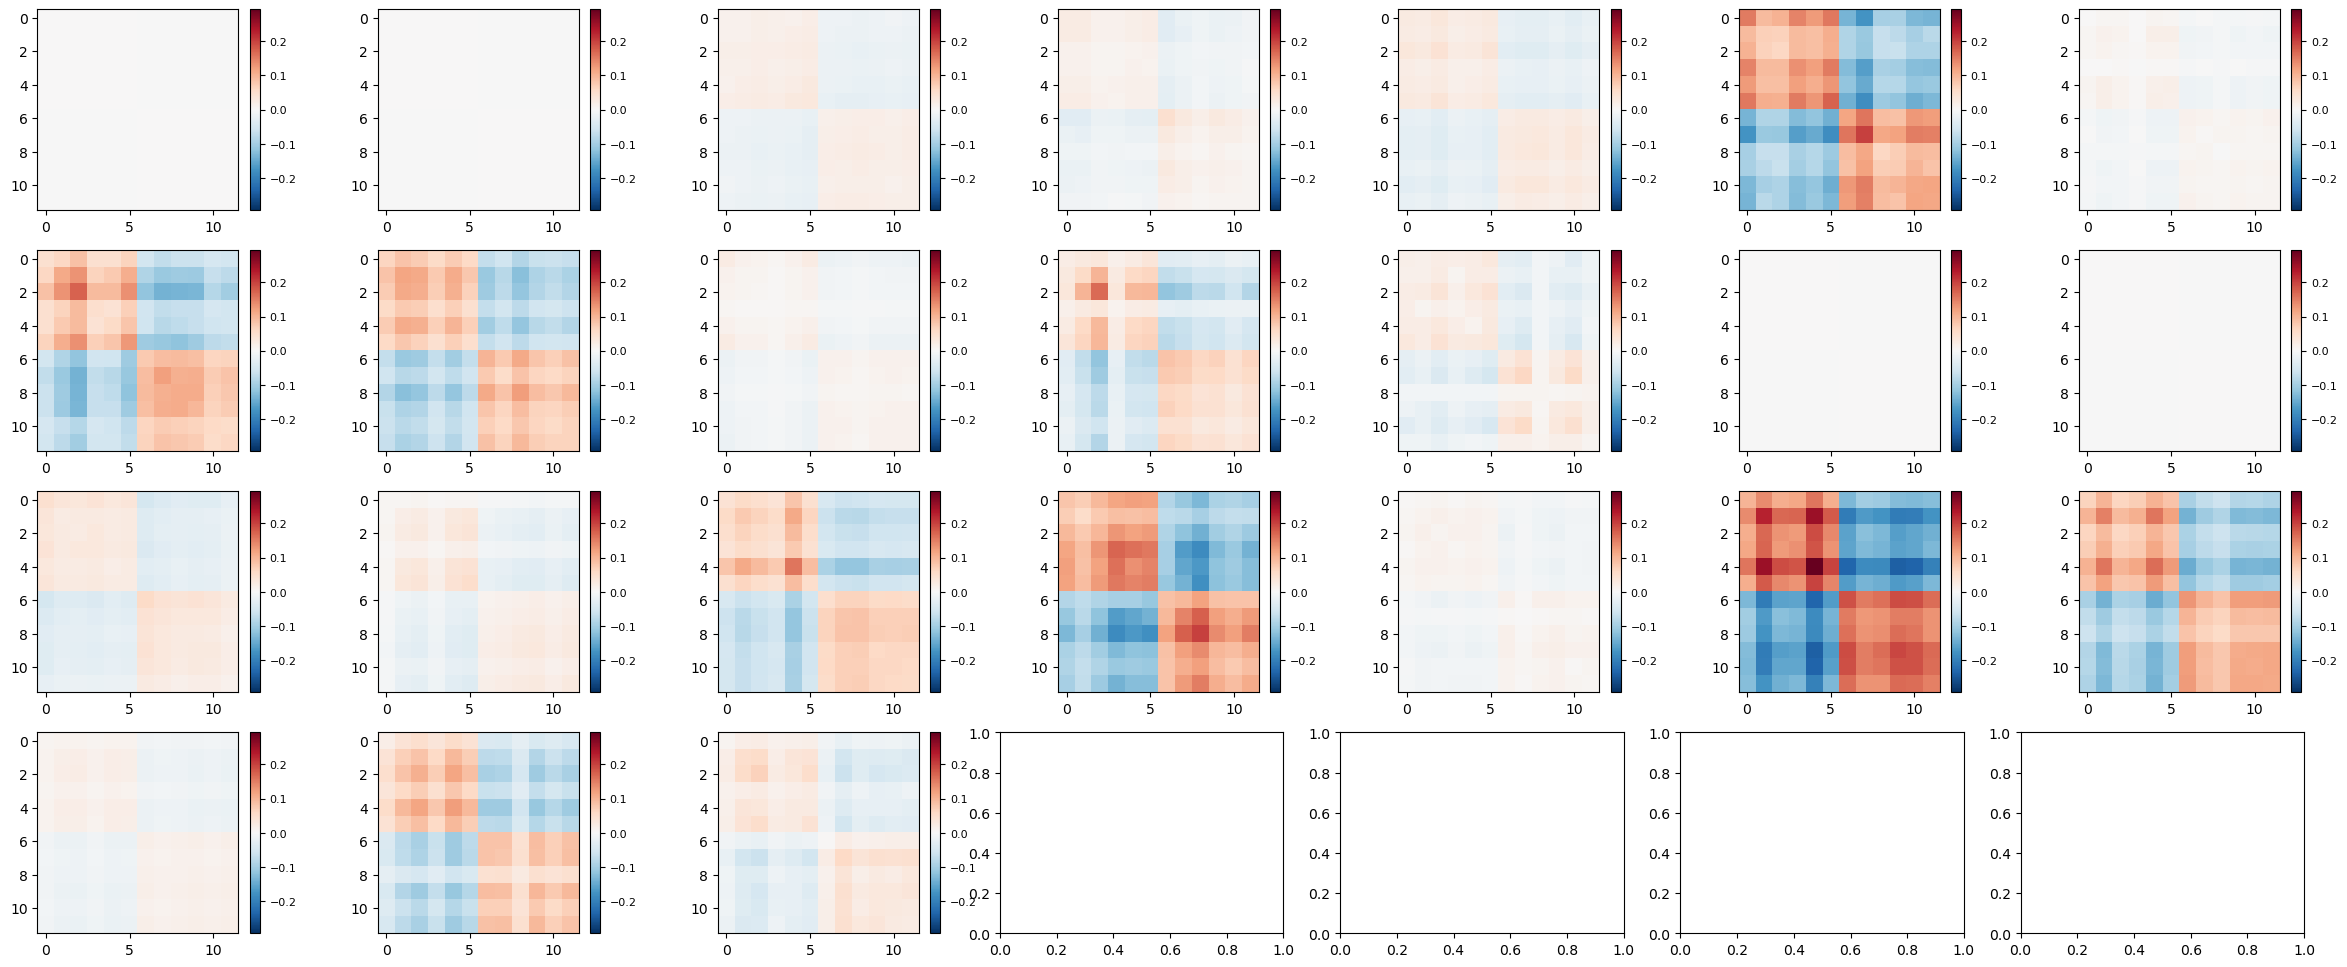

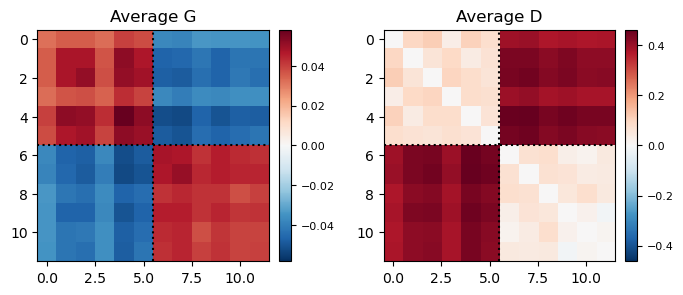

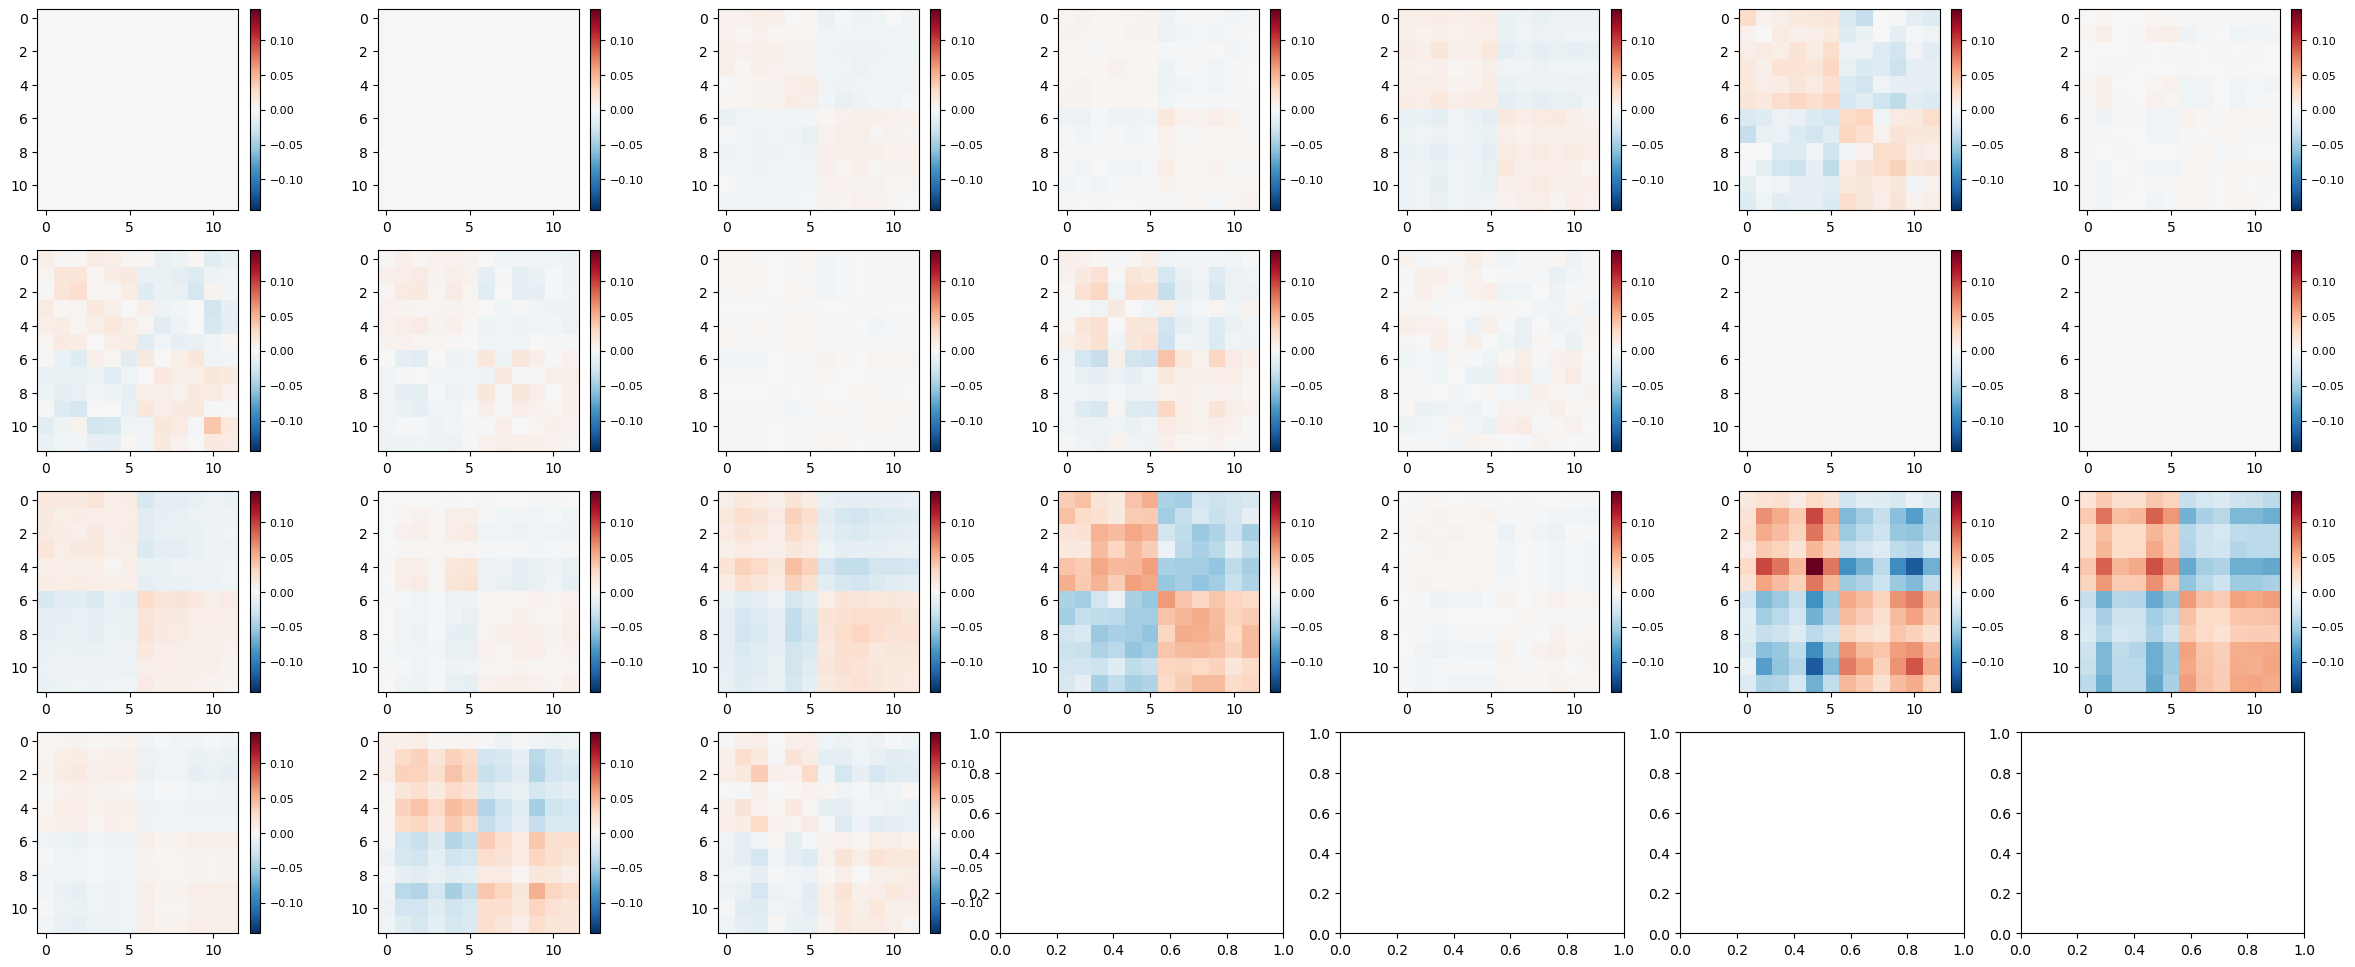

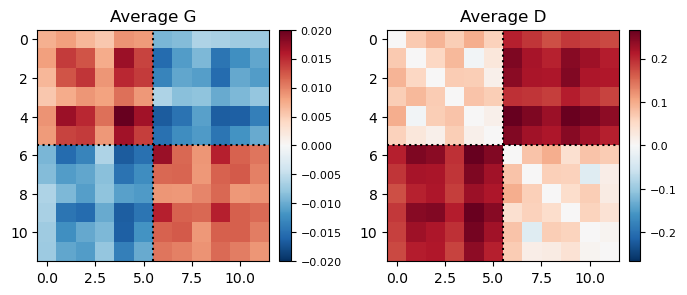

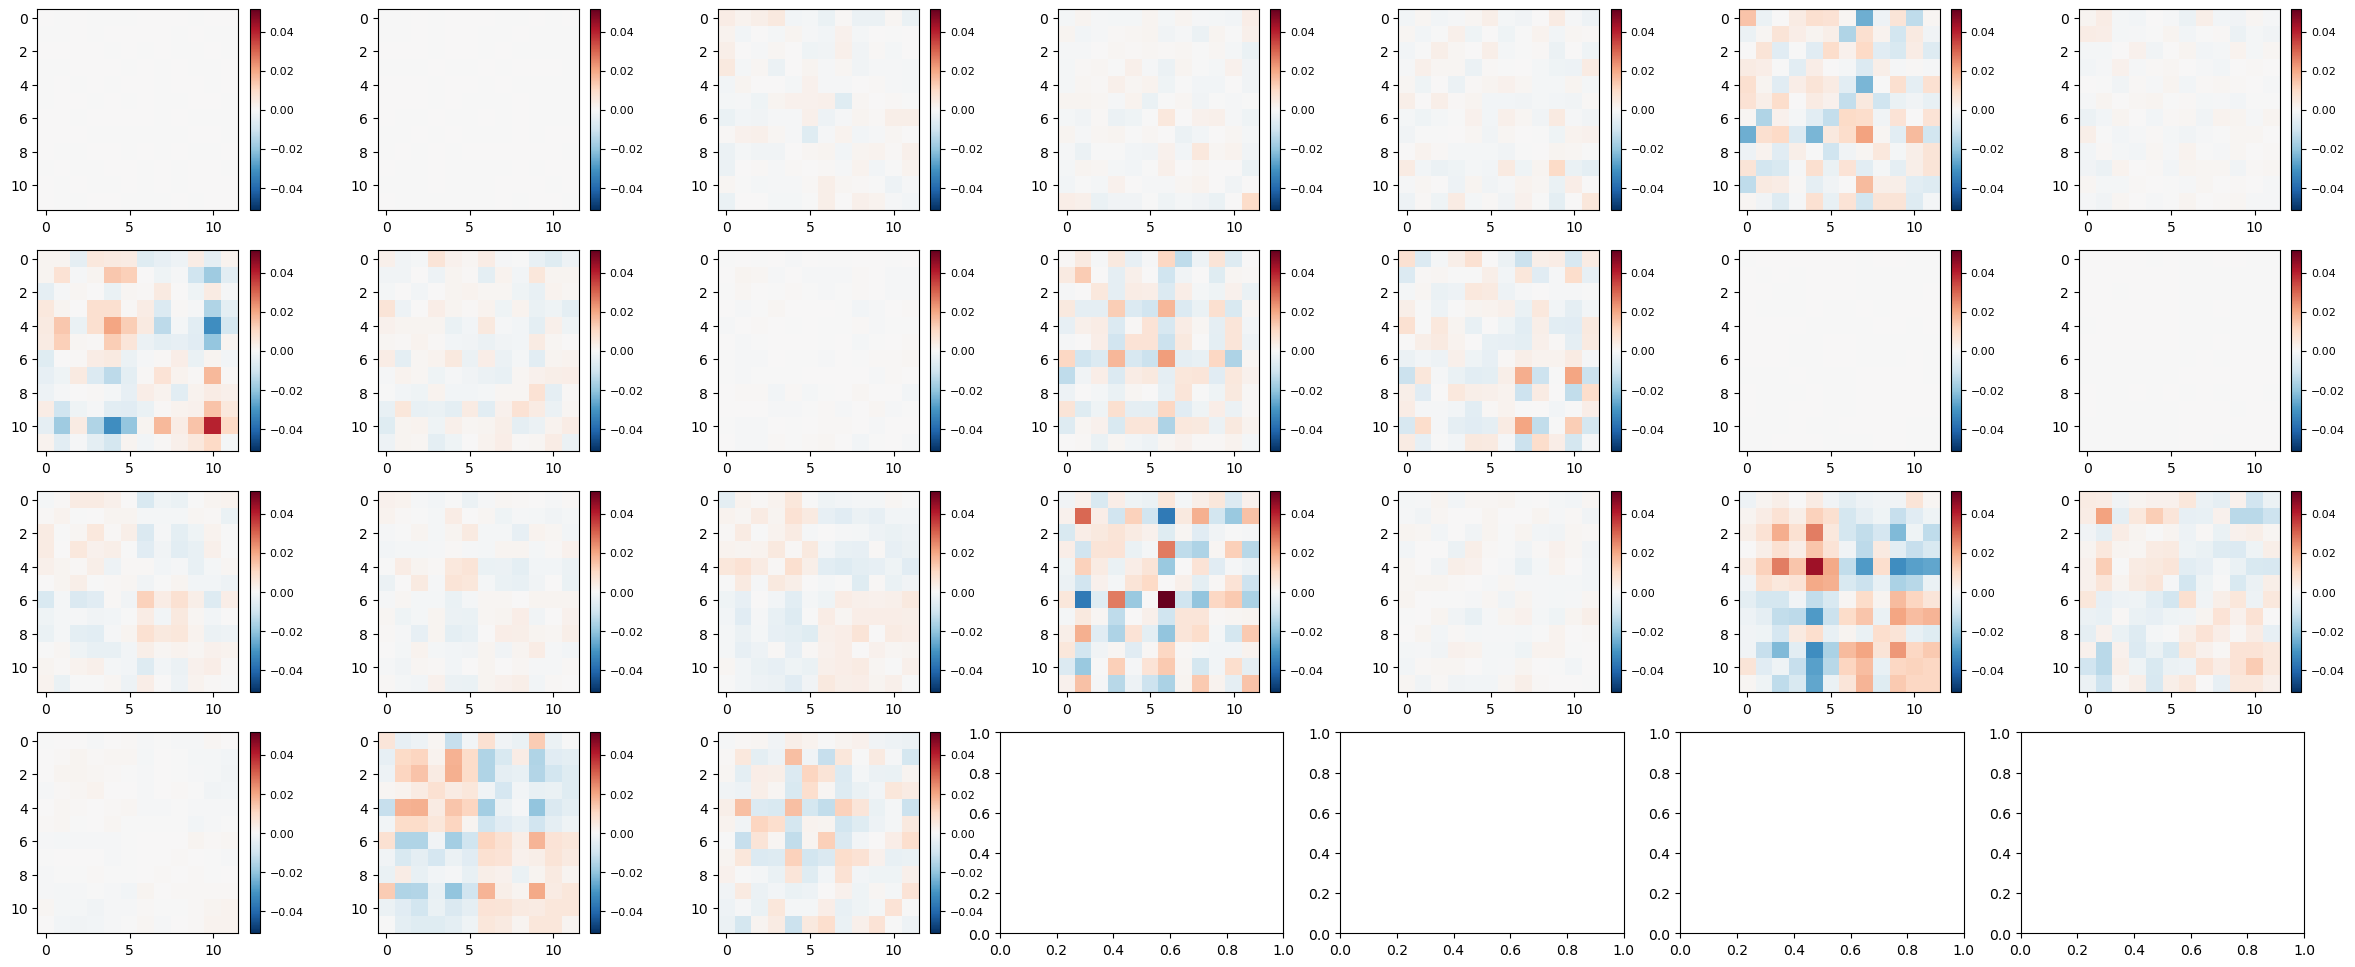

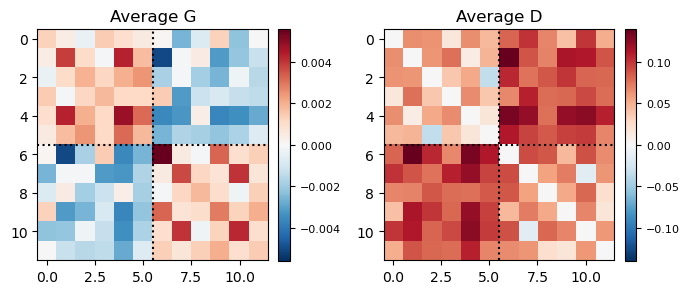

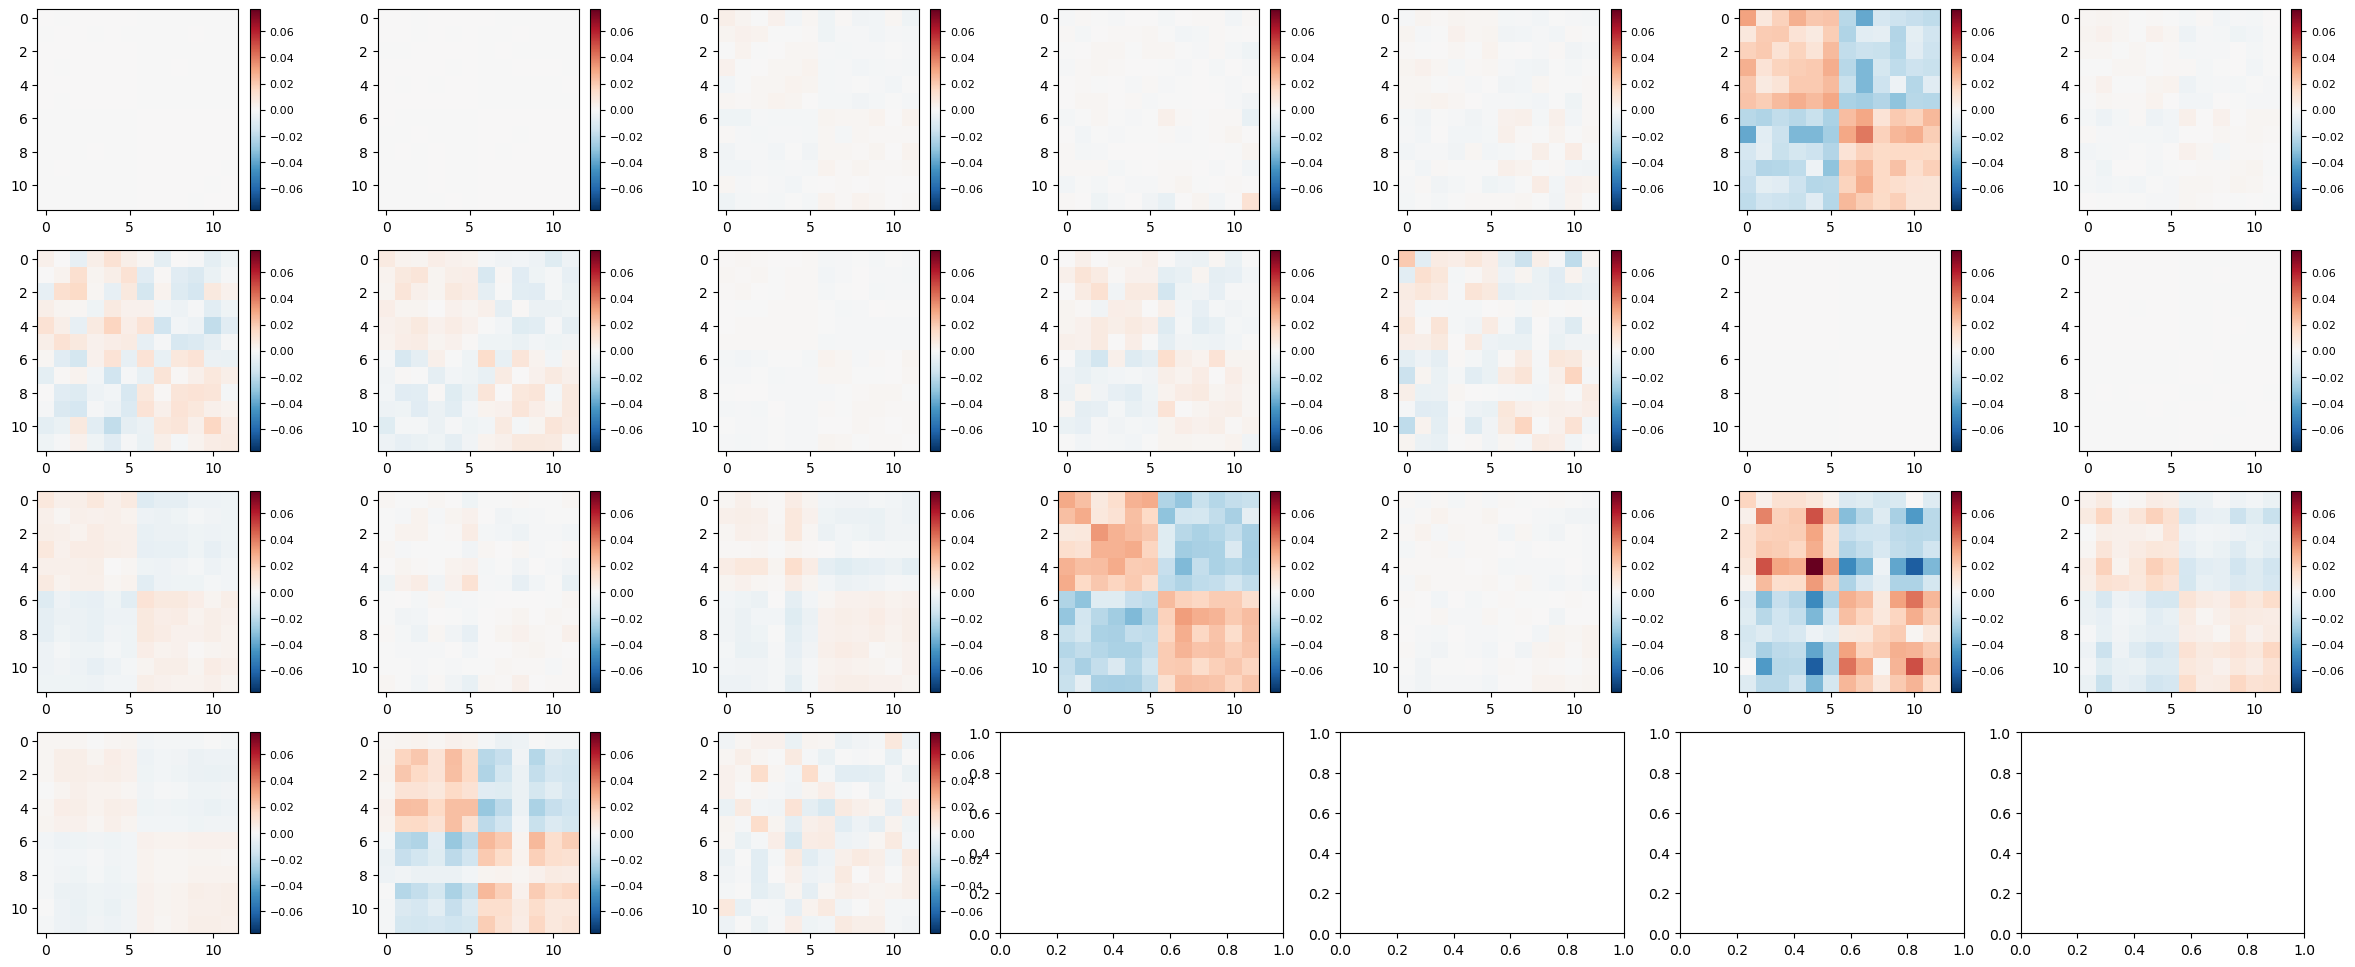

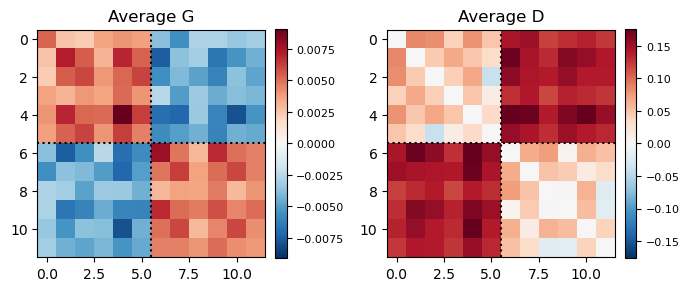

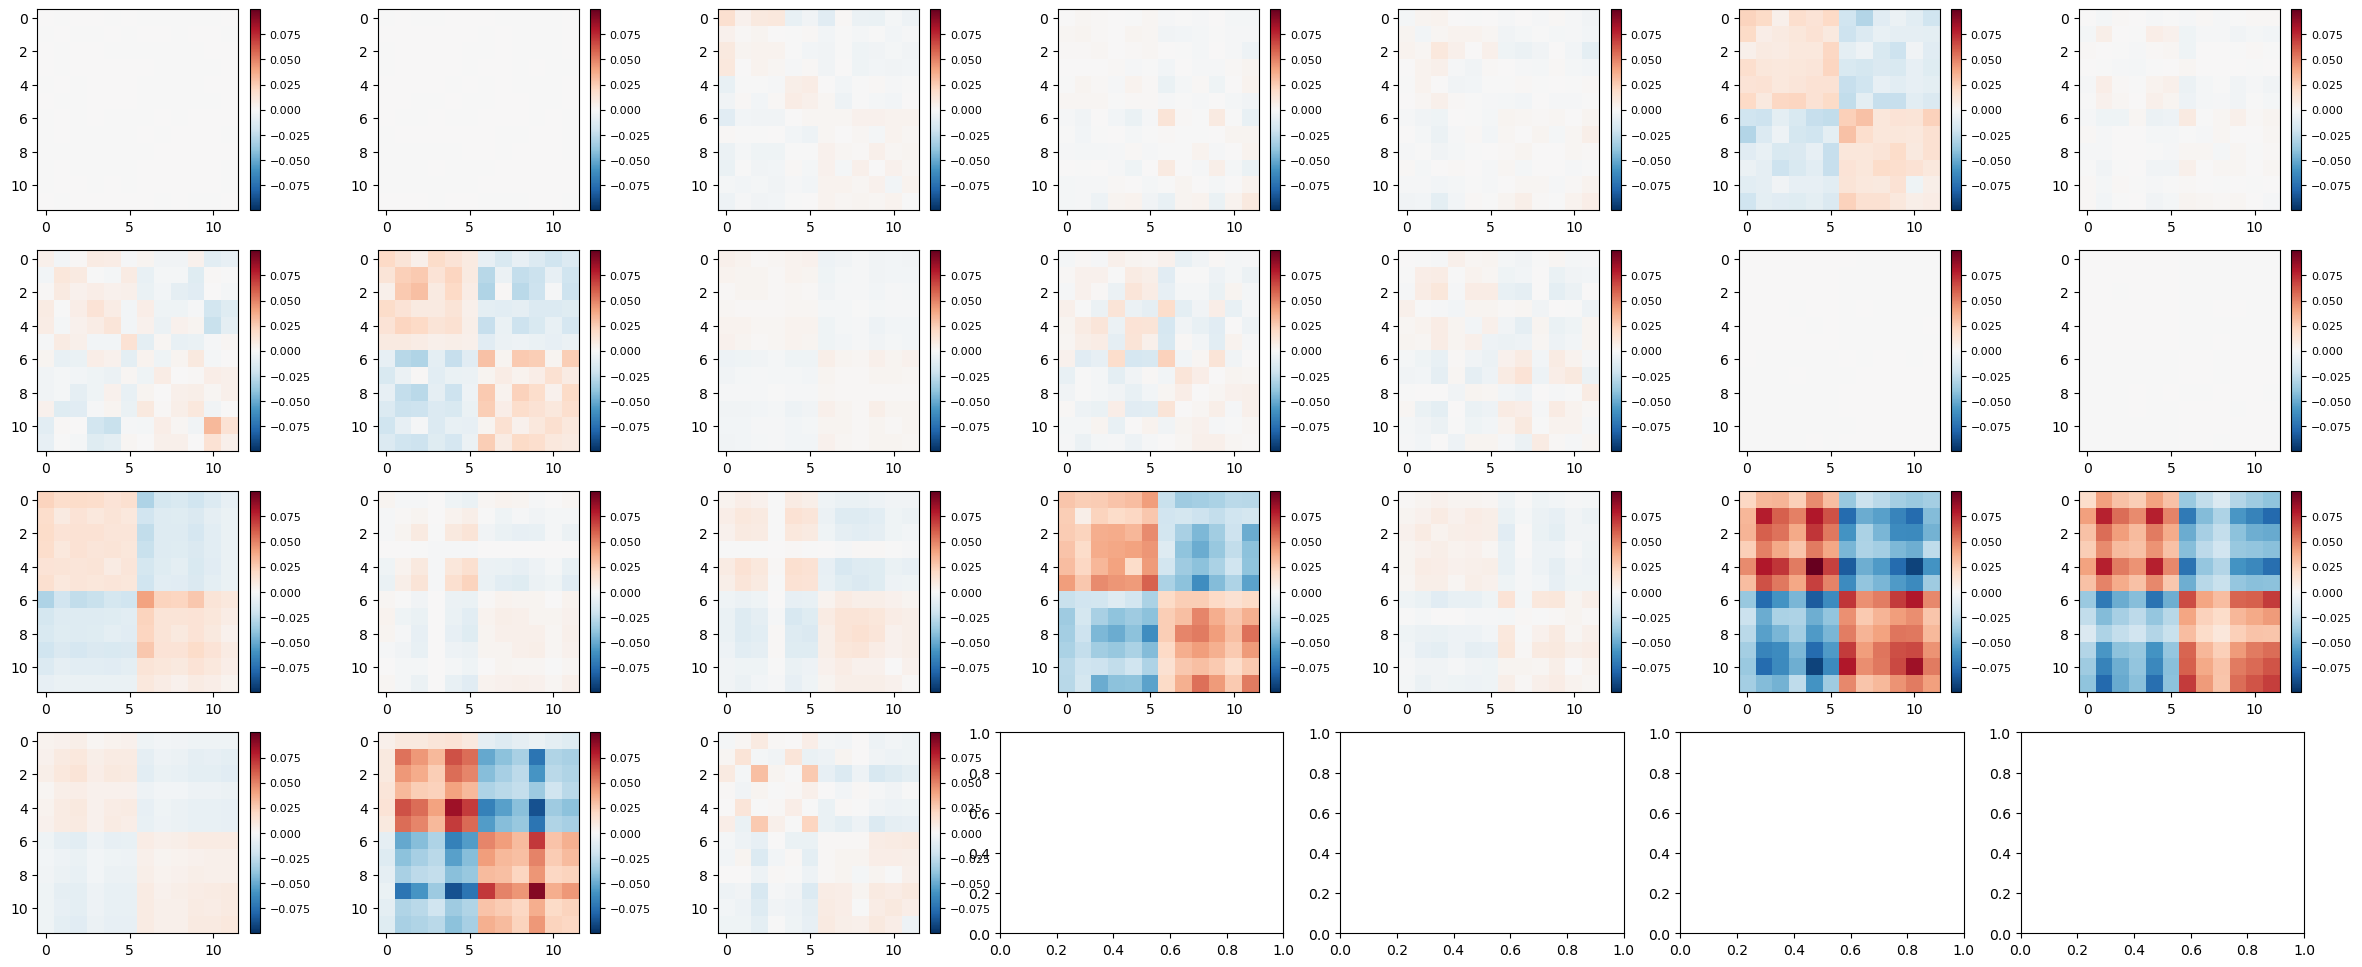

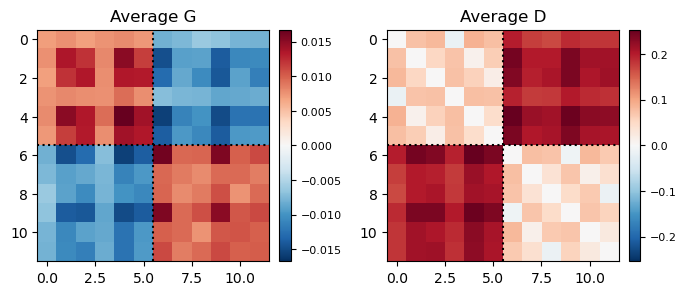

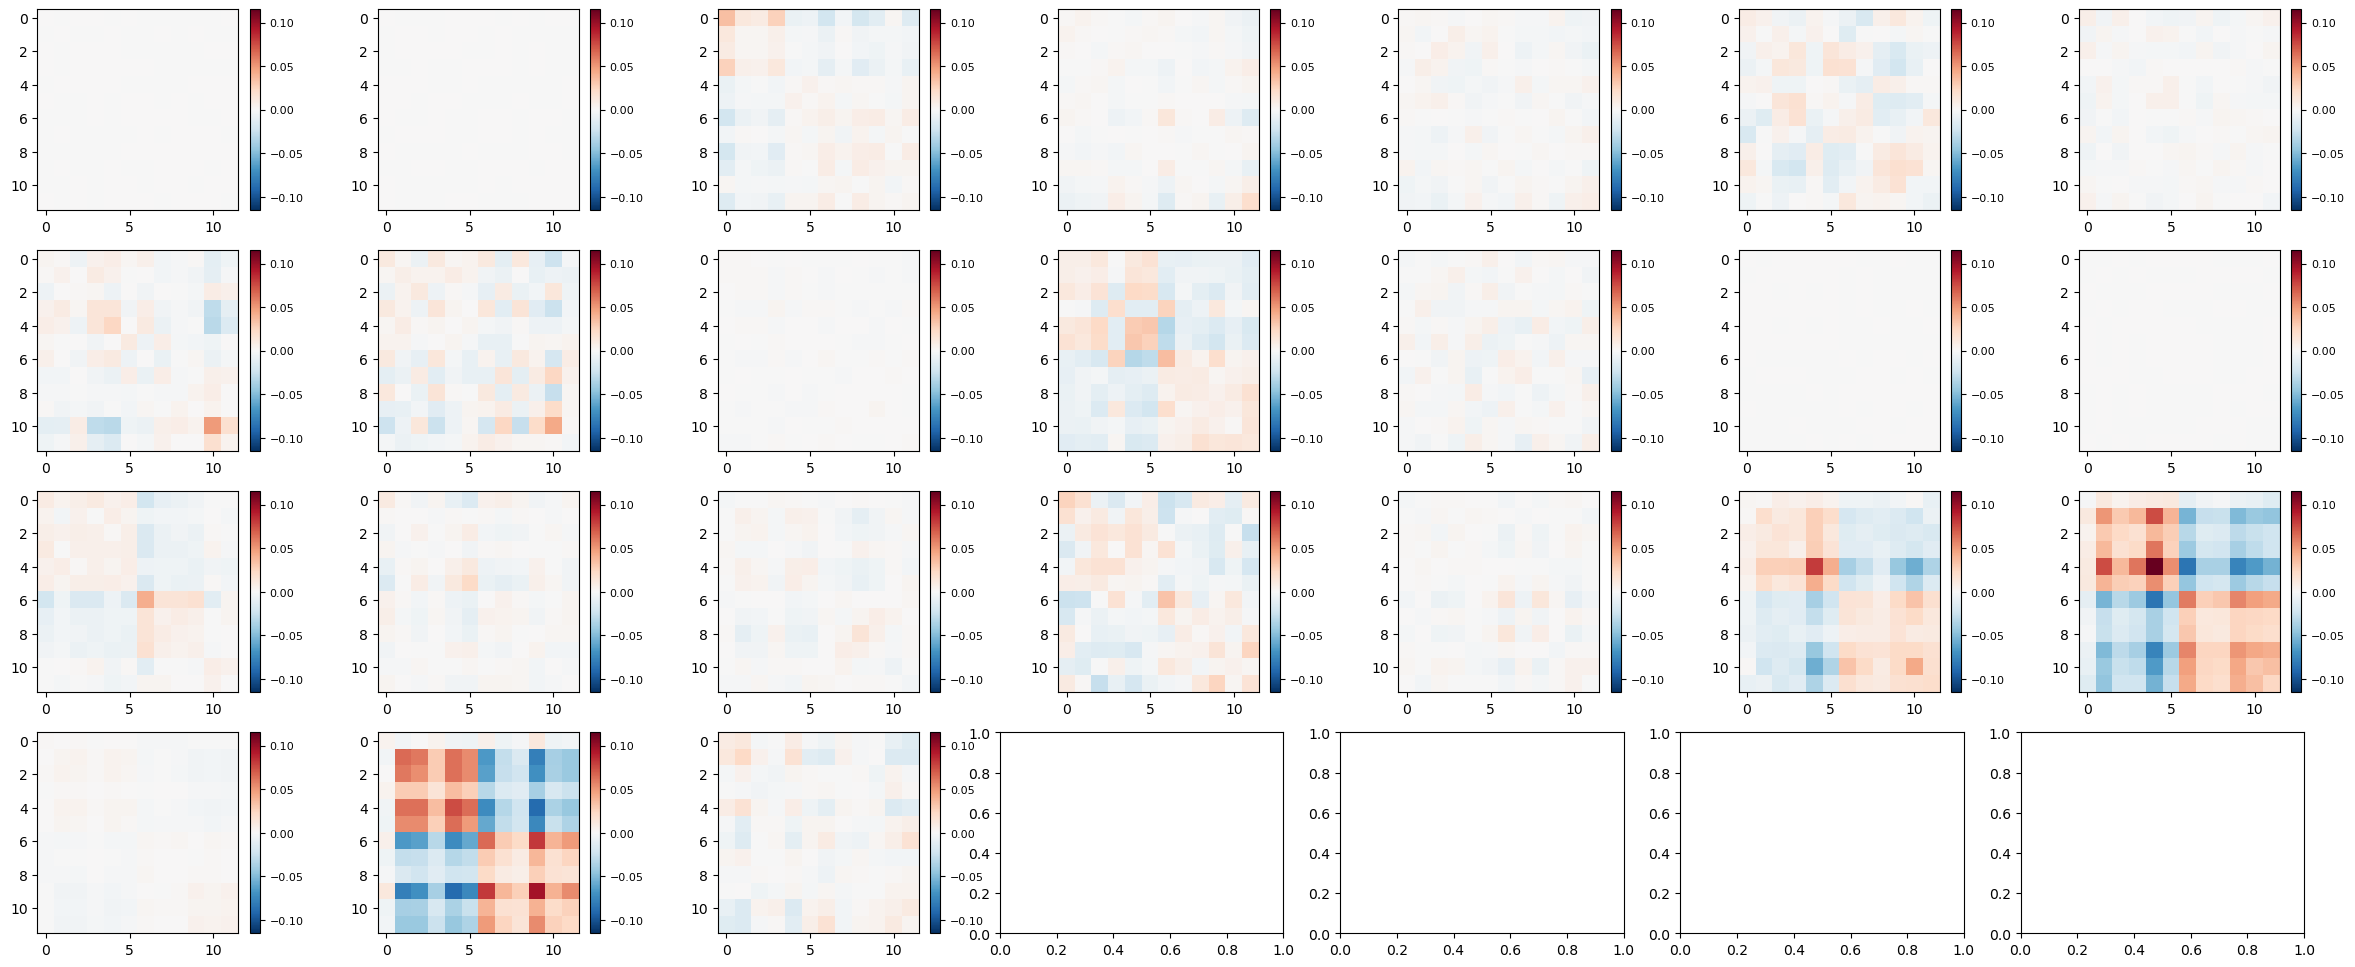

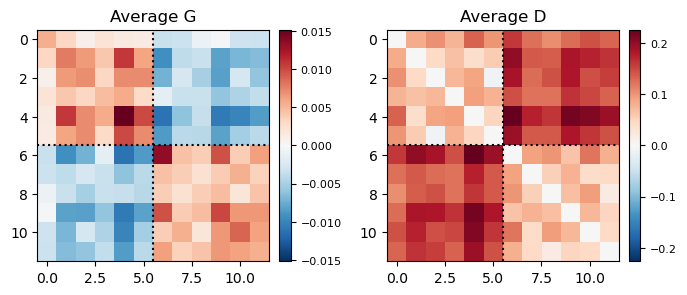

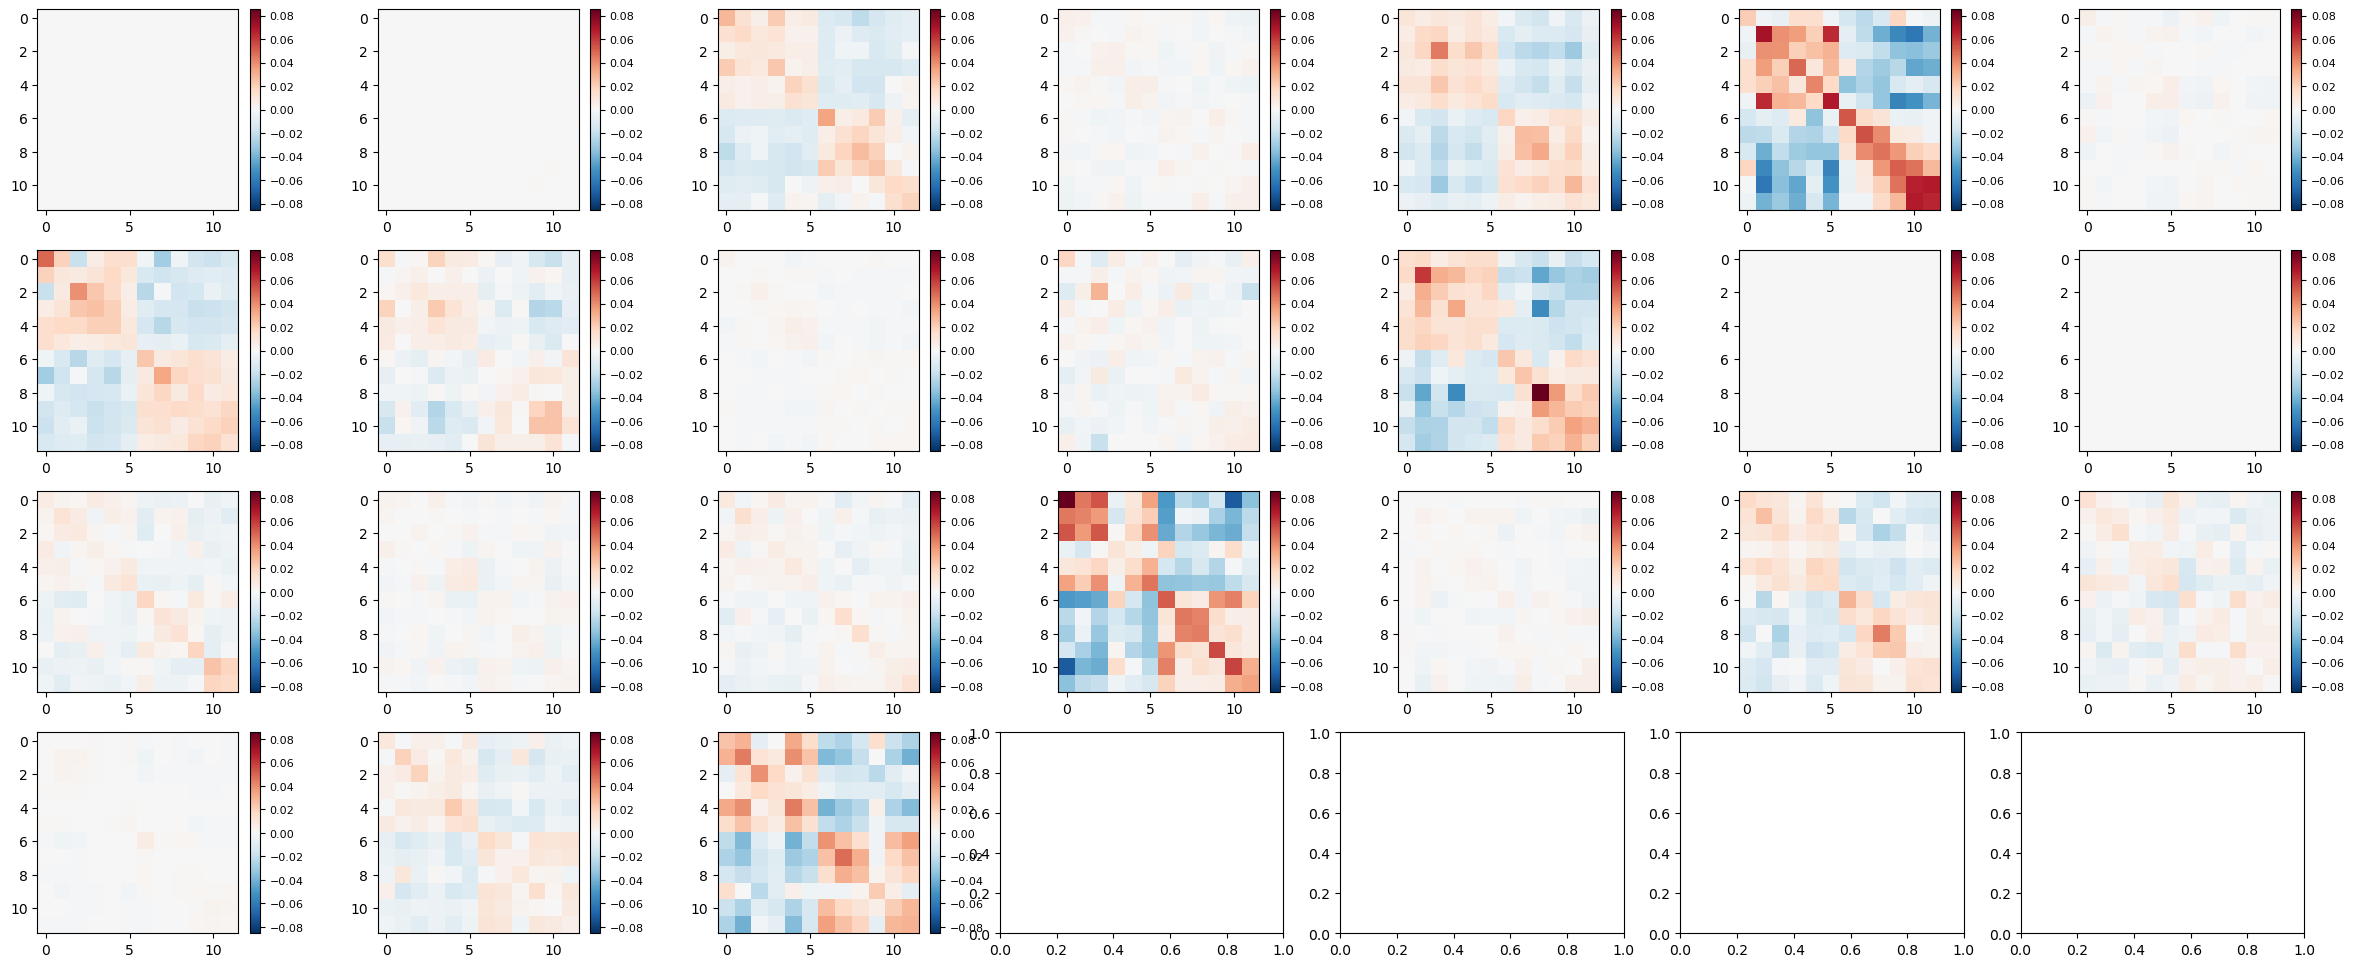

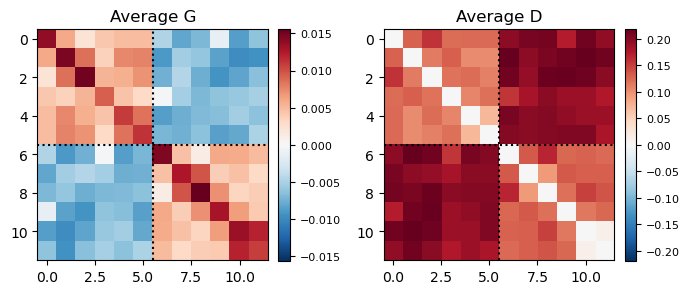

In [ ]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_extrinsic = ['0','60','120','180','240','300']*2
labels_lateral = ['contra']*6 + ['ipsi']*6
cmap = 'RdBu_r'
sn_bad = [102, 103]
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
hem = ['L','R']
for region in regions:
    data, cond_vec, part_vec = [], [], []
    for i_hem, h in enumerate(hem):
        roi = f'{region}_{h}'
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]

        subject = d['subject'][indices]
        cond_name_tmp = d['cond_extrinsic_vec'][indices]
        cond_vec_tmp = d['cond_num_vec_extrinsic'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]

        for i_sub in range(len(subject)):
            idx1 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'rhand' in c]
            idx2 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'lhand' in c]
            idx = idx1 + idx2
            # Y = data_tmp[i_sub][idx, :]
            Y1 = data_tmp[i_sub][idx1, :]
            Y2 = data_tmp[i_sub][idx2, :]

            # remove mean of voxels across conditions of rhand:
            # rhand_parts = part_tmp[i_sub][idx1]
            # for p in np.unique(rhand_parts):
            #     Y1[rhand_parts == p, :] = Y1[rhand_parts == p, :] - np.mean(Y1[rhand_parts == p, :], axis=0)
            # # remove mean of voxels across conditions of lhand:
            # lhand_parts = part_tmp[i_sub][idx2]
            # for p in np.unique(lhand_parts):
            #     Y2[lhand_parts == p, :] = Y2[lhand_parts == p, :] - np.mean(Y2[lhand_parts == p, :], axis=0)
            Y = np.vstack((Y1, Y2))
            
            subj_part = part_tmp[i_sub][idx]
            # Sort based on Hemisphere to have contralateral first:
            if h == 'L':
                subj_cond = cond_vec_tmp[i_sub][idx]
                tmp = subj_cond.copy()
                subj_cond[tmp > 5] = tmp[tmp > 5] - 6
                subj_cond[tmp <= 5] = tmp[tmp <= 5] + 6 
            elif h == 'R':
                subj_cond = cond_vec_tmp[i_sub][idx]

            data.append(Y)
            cond_vec.append(np.array(subj_cond))
            part_vec.append(subj_part)

    Y = []
    # --- RDM Calculation ---
    for i_sub in range(len(data)):
        obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
        Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

    N = len(Y)
    ncond = len(np.unique(Y[0].obs_descriptors['cond_vec']))
    G_hat = np.zeros((N, ncond, ncond))
    for i_sub in range(N):
        G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                    Y[i_sub].obs_descriptors['cond_vec'],
                                                    Y[i_sub].obs_descriptors['part_vec'],
                                                    X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))

    # show all second moment matrices
    # cmap = 'RdBu_r'
    # fig,ax = plt.subplots(4,7,figsize=(30,12))
    # vmax = np.abs(G_hat).max()
    # for i in range(N):
    #     ax[i//7,i%7].imshow(G_hat[i,:,:],vmin=-vmax,vmax=vmax,cmap=cmap)
    #     # color bar:
    #     sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
    #     sm.set_array([])
    #     cbar = plt.colorbar(sm, ax=ax[i//7,i%7], fraction=0.046, pad=0.04)
    #     cbar.ax.tick_params(labelsize=8)

    # avg:
    # fig, ax = plt.subplots(1,2,figsize=(7,3))
    # G_hat_avg = np.mean(G_hat, axis=0)
    # # G_hat_avg = G_hat_avg / np.trace(G_hat_avg)
    # vmax_avg = np.abs(G_hat_avg).max()
    # ax[0].imshow(G_hat_avg, vmin=-vmax_avg, vmax=vmax_avg, cmap=cmap)
    # sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax_avg, vmax=vmax_avg))
    # sm.set_array([])
    # cbar = plt.colorbar(sm, ax=ax[0], fraction=0.046, pad=0.04)
    # cbar.ax.tick_params(labelsize=8)
    # ax[0].set_title(f'Average G')
    # ax[0].axhline(5.5, color='k', linestyle=':', linewidth=1.5)
    # ax[0].axvline(5.5, color='k', linestyle=':', linewidth=1.5)

    # D_avg = pcm.G_to_dist(G_hat_avg)
    # D_avg = np.sign(D_avg) * np.sqrt(np.abs(D_avg))
    # vmax = np.abs(D_avg).max()
    # ax[1].imshow(D_avg, vmin=-vmax, vmax=vmax, cmap=cmap)
    # sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
    # sm.set_array([])
    # cbar = plt.colorbar(sm, ax=ax[1], fraction=0.046, pad=0.04)
    # cbar.ax.tick_params(labelsize=8)
    # ax[1].set_title(f'Average D')
    # ax[1].axhline(5.5, color='k', linestyle=':', linewidth=1.5)
    # ax[1].axvline(5.5, color='k', linestyle=':', linewidth=1.5)
    # plt.tight_layout()
    # plt.show()

    # save PCM dataset (Y):
    file_path_save = os.path.join(analysisDir, f'pcm_dataset_extrinsic_12by12_{region}.npz')
    np.savez(file_path_save, Y=Y, cond_vec=cond_vec, part_vec=part_vec)

    # # save mean G:
    # file_path_save = os.path.join(analysisDir, f'pcm_Ghat_avg_12by12_{region}.npz')
    # np.savez(file_path_save, G_hat=G_hat_avg)



